- Evaluate Simplenetwork ?
- Optuna Training
- Best Optuna Training
- WGAN -Training 

What gets the Best Optuna Model well on test set an what not. 
- Accuracy under the number of true classes on test set
- Number of data for each number of true classes

Number of Occurances of every class and the accuracy on that class 


Dim-Reduction -> Wichtigkeit der Dimensionen und dann Accuracy mit dem Optuna Model auf Valdaten mit den gewählten Dims -> tSNE or PCA

In [1]:
import sys
import os
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
sys.path.append("../../")
from utils.evaluation import evaluate
from utils.metrics import Metrics

In [2]:
import pickle
from git import Repo

# Get the git root directory
repo = Repo(".", search_parent_directories=True)
git_root = repo.git.rev_parse("--show-toplevel")

# Load data
X_Train_pd = pickle.load(open(f"{git_root}/data/splits/train/X_pandas.pck", "rb"))
y_Train_pd = pickle.load(open(f"{git_root}/data/splits/train/y_pandas.pck", "rb"))

X_Val_pd = pickle.load(open(f"{git_root}/data/splits/val/X_pandas.pck", "rb"))
y_Val_pd = pickle.load(open(f"{git_root}/data/splits/val/y_pandas.pck", "rb"))

X_test_pd = pickle.load(open(f"{git_root}/data/splits/test/X_pandas.pck", "rb"))
y_test_pd = pickle.load(open(f"{git_root}/data/splits/test/y_pandas.pck", "rb"))

# Convert to tensors
X_train = torch.tensor(X_Train_pd.values, dtype=torch.float32)
y_train = torch.tensor(y_Train_pd.values, dtype=torch.float32)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False)

X_val = torch.tensor(X_Val_pd.values, dtype=torch.float32)
y_val = torch.tensor(y_Val_pd.values, dtype=torch.float32)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

X_test = torch.tensor(X_test_pd.values, dtype=torch.float32)
y_test = torch.tensor(y_test_pd.values, dtype=torch.float32)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

In [3]:
class SimpleNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(5045, 3934),
            torch.nn.LeakyReLU(0.26250042355767117),
            torch.nn.BatchNorm1d(3934),
            torch.nn.Dropout(p=0.26081286435916),
            torch.nn.Linear(3934, 2246),
            torch.nn.LeakyReLU(0.26250042355767117),
            torch.nn.BatchNorm1d(2246),
            torch.nn.Dropout(p=0.26081286435916),
            torch.nn.Linear(2246, 1955),
            torch.nn.LeakyReLU(0.26250042355767117),
            torch.nn.BatchNorm1d(1955),
            torch.nn.Dropout(p=0.26081286435916),
            torch.nn.Linear(1955, 745),
            torch.nn.LeakyReLU(0.26250042355767117),
            torch.nn.BatchNorm1d(745),
            torch.nn.Dropout(p=0.26081286435916),
            torch.nn.Linear(745, 702),
            torch.nn.LeakyReLU(0.26250042355767117),
            torch.nn.BatchNorm1d(702),
            torch.nn.Dropout(p=0.26081286435916),
            torch.nn.Linear(702, 105),
        )

        # Apply Xavier initialization
        for layer in self.layers:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        return self.layers(x)

In [4]:
def label_from_logits(y_hat: torch.Tensor, threshold = 0.5) -> torch.Tensor:
    with torch.no_grad():
        y_pred_tensor = (torch.sigmoid(y_hat) > threshold).float()
    return y_pred_tensor



In [5]:
model = SimpleNetwork()

# Load model
model.load_state_dict(torch.load(f"{git_root}/evaluation/NeuronalNetwork/data/BestOptuna/model.pt"))

C:\Users\Julius\AppData\Local\Temp\ipykernel_4960\1406653280.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{git_root}/evaluation/Neu

<All keys matched successfully>

In [13]:
model.eval()



def evaluate_model(threshold):
    y_hat_test = torch.tensor([])
    y_hat_train = torch.tensor([])
    y_hat_val = torch.tensor([])
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_dataloader):
            logits = model(X_batch)
            y_hat_test = torch.cat((y_hat_test, label_from_logits(logits, threshold=threshold)), 0)
        y_hat_test = y_hat_test.numpy()
        for X_batch, y_batch in tqdm(train_dataloader):
            logits = model(X_batch)
            y_hat_train = torch.cat((y_hat_train, label_from_logits(logits, threshold=threshold)), 0)
        y_hat_train = y_hat_train.numpy()
        for X_batch, y_batch in tqdm(val_dataloader):
            logits = model(X_batch)
            y_hat_val = torch.cat((y_hat_val, label_from_logits(logits, threshold=threshold)), 0)
        y_hat_val = y_hat_val.numpy()

    return y_hat_train, y_hat_val, y_hat_test

In [25]:
y_hat_train, y_hat_val, y_hat_test = evaluate_model(threshold=0.5)

metrics_test = Metrics(y_hat_test, y_test.to(y_hat_test.device).numpy())
metrics_train = Metrics(y_hat_train, y_train.to(y_hat_train.device).numpy())
metrics_val = Metrics(y_hat_val, y_val.to(y_hat_val.device).numpy())

print(f"Metrics Test: {metrics_test.as_dict()}")
print(f"Metrics Train: {metrics_train.as_dict()}")
print(f"Metrics Val: {metrics_val.as_dict()}")

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/286 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Metrics Test: {'accuracy': 0.48486842105263156, 'precision': 0.7175926497830036, 'recall': 0.5312653983812686, 'auc': np.float64(0.7644264942765617), 'f1_score': 0.5969241424947132}
Metrics Train: {'accuracy': 0.9395052422394299, 'precision': 0.9802577679660511, 'recall': 0.9377094441892853, 'auc': np.float64(0.9687440790650383), 'f1_score': 0.9562176916844453}
Metrics Val: {'accuracy': 0.4941885964912281, 'precision': 0.7315725453523074, 'recall': 0.540013005061243, 'auc': np.float64(0.7689018794661082), 'f1_score': 0.6085700519950478}


In [40]:
# Split the test labels into parts depending on the number of true classes
y_test_np = y_test_pd.values
y_train_np = y_Train_pd.values


# Split the test predictions into parts depending on the number of true classes
y_hat_test_parts = np.empty(3, dtype=object)
metrics_test_parts = np.empty(3, dtype=object)
accuracy_test_parts = np.empty(3, dtype=object)
test_parts_size = np.empty(3, dtype=object)
mean_mask_counts = np.empty(3, dtype=object)

for i in range(3):
    y_hat_test_parts[i] = y_hat_test[np.sum(y_test_np, axis=1) == i]
    y_test_part = y_test_np[np.sum(y_test_np, axis=1) == i]
    y_train_part = y_train[np.sum(y_train_np, axis=1) == i]
    metrics_test_parts[i] = Metrics(y_hat_test_parts[i], y_test_part)
    accuracy_test_parts[i] = metrics_test_parts[i].as_dict()["accuracy"]
    test_parts_size[i] = len(y_test_part)
    unique_masks, counts = np.unique(y_train_part, axis=0, return_counts=True)
    mean_mask_counts[i] = np.mean(counts) 

size_total = np.sum(test_parts_size)


c:\Users\Julius\Documents\LuH\rna_sequencing\.venv\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Julius\Documents\LuH\rna_sequencing\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Julius\Documents\LuH\rna_sequencing\.venv\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Julius\Documents\LuH\rna_sequencing\.venv\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that c

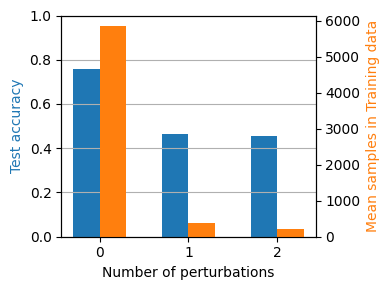

In [48]:
# Plot accuracy and number of samples as barplot
fig, ax1 = plt.subplots(figsize=(4, 3))
bar_width = 0.3
index = np.arange(3)

# Plot accuracy on the first y-axis
ax1.bar(index, accuracy_test_parts, bar_width, label="Test accuracy", color='tab:blue')
ax1.set_xlabel("Number of perturbations")
ax1.set_ylabel("Test accuracy", color='tab:blue')
ax1.tick_params(axis='y')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels([str(i) for i in range(3)])
ax1.grid(axis='y')
ax1.set_ylim(0, 1)

# Create a second y-axis for the number of samples
ax2 = ax1.twinx()
ax2.bar(index + bar_width, mean_mask_counts, bar_width, label="Samples in training data (normalized)", color='tab:orange')
ax2.set_ylabel("Mean samples in Training data", color='tab:orange')
ax2.tick_params(axis='y')

fig.tight_layout()

plt.show()
